<a href="https://colab.research.google.com/github/ucalyptus/Jay-Hind-Project/blob/master/Colorify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/jantic/DeOldify.git DeOldify

Cloning into 'DeOldify'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 1143 (delta 11), reused 5 (delta 2), pack-reused 1122
Receiving objects: 100% (1143/1143), 69.02 MiB | 32.84 MiB/s, done.
Resolving deltas: 100% (398/398), done.


In [2]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

    100% |████████████████████████████████| 483.0MB 44.8MB/s 
fastai 1.0.49 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
fastai 1.0.49 has requirement torch>=1.0.0, but you'll have torch 0.4.1 which is incompatible.
0.4.1
True


In [3]:
cd DeOldify

/content/DeOldify


In [4]:
!pip install -e .

Obtaining file:///content/DeOldify
    100% |████████████████████████████████| 1.5MB 15.5MB/s 
    100% |████████████████████████████████| 3.6MB 7.9MB/s 
    100% |████████████████████████████████| 133kB 28.8MB/s 
    100% |████████████████████████████████| 12.4MB 3.9MB/s 
    100% |████████████████████████████████| 61kB 22.4MB/s 
    100% |████████████████████████████████| 81kB 24.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/9f/78/26/fb8c0acb91a100dc8914bf236c4eaa4b207cb876893c40b745
  Stored in directory: /root/.cache/pip/wheels/85/7d/12/2dfa5c0195f921ac935f5e8f27deada74972edc0ae9988a9c1
Successfully built bcolz feather-format
mizani 0.5.3 has requirement pandas>=0.23.4, but you'll have pandas 0.22.0 which is incompatible.
plotnine 0.5.1 has requirement pandas>=0.23.4, but you'll have pandas 0.22.0 which is incompatible.
  Found existing installation: fastai 1.0.49
    Uninstalling fastai-1.0.49:
      Successfully uninstalled fastai-1.0.49
  Running setup.py develop for fas

In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [6]:
# Doing work so I can access data from my google drive
!pip install PyDrive

    100% |████████████████████████████████| 993kB 20.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built PyDrive


In [7]:
# Work around with Pillow being preinstalled on these Colab VMs, causing conflicts otherwise.
!pip install Pillow==4.1.1

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import multiprocessing
from torch import autograd
from fastai.transforms import TfmType
from fasterai.transforms import *
from fastai.conv_learner import *
from fasterai.images import *
from fasterai.dataset import *
from fasterai.visualize import *
from fasterai.callbacks import *
from fasterai.loss import *
from fasterai.modules import *
from fasterai.training import *
from fasterai.generators import *
from fastai.torch_imports import *
from fasterai.filters import *
from pathlib import Path
from itertools import repeat
from google.colab import drive
from IPython.display import Image
import tensorboardX
torch.cuda.set_device(0)
plt.style.use('dark_background')
torch.backends.cudnn.benchmark=True

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Note that the above requires a verification step. It isn't too bad.

In [0]:
# Now download the pretrained weights, which I have saved to my google drive
# note that the id is the ending part of the shareable link url (after open?id=)
# The pretrained weights can be downloaded from https://www.dropbox.com/s/7r2wu0af6okv280/colorize_gen_192.h5
download = drive.CreateFile({'id': '1mRRvS3WIHPdp36G0yc1jC0XI6i-Narv6'})
download.GetContentFile('pretrained_weights.h5')

With access to your Google Drive, the "deOldifyImages" directory will be created. Drop there your personal images, and after the full execution of the notebook find the results at its subdirectory "results"

In [11]:
from google.colab import drive
drive.mount('/content/drive')
!mkdir "/content/drive/My Drive/deOldifyImages"
!mkdir "/content/drive/My Drive/deOldifyImages/results"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [12]:
weights_path = 'pretrained_weights.h5'
results_dir='/content/drive/My Drive/deOldifyImages/results'

#The higher the render_factor, the more GPU memory will be used and generally images will look better.  
#11GB can take a factor of 42 max.  Performance generally gracefully degrades with lower factors, 
#though you may also find that certain images will actually render better at lower numbers.  
#This tends to be the case with the oldest photos.
render_factor=42
filters = [Colorizer34(gpu=0, weights_path=weights_path)]
vis = ModelImageVisualizer(filters, render_factor=render_factor, results_dir=results_dir)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 85682917.66it/s]


Let's see how well it does Dorothy before her world turns to color in the Wizard of Oz:

--2019-03-22 12:12:26--  https://s01.sgp1.cdn.digitaloceanspaces.com/article/39524-sqggaftepq-1471281419.jpeg
Resolving s01.sgp1.cdn.digitaloceanspaces.com (s01.sgp1.cdn.digitaloceanspaces.com)... 205.185.216.42, 205.185.216.10
Connecting to s01.sgp1.cdn.digitaloceanspaces.com (s01.sgp1.cdn.digitaloceanspaces.com)|205.185.216.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59791 (58K) [binary/octet-stream]
Saving to: ‘Netaji.jpg’

Netaji.jpg          100%[===================>]  58.39K  --.-KB/s    in 0.01s   

2019-03-22 12:12:26 (5.43 MB/s) - ‘Netaji.jpg’ saved [59791/59791]



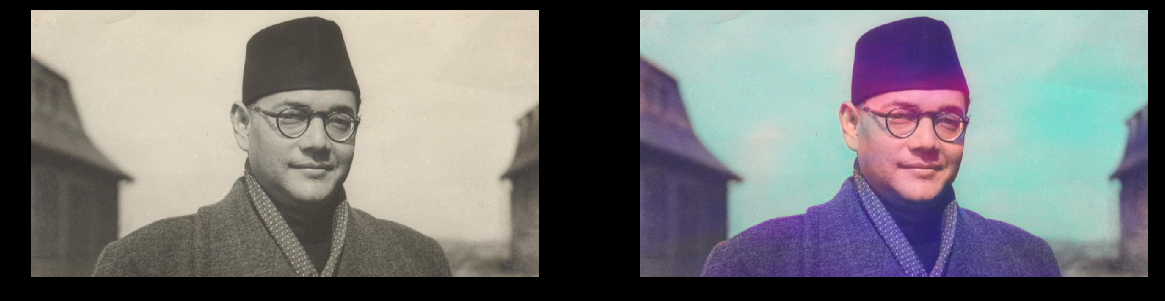

In [17]:
!wget  "https://s01.sgp1.cdn.digitaloceanspaces.com/article/39524-sqggaftepq-1471281419.jpeg" -O "Netaji.jpg"
vis.plot_transformed_image('Netaji.jpg', render_factor=30)


Let's now try Butch and Sundance. Famously the last scene ends with a black and white still. So we know what the color was beforehand.

Let's get a picture of what they were actually wearing:

If you want to colorise pictures from your drive, drop them in a directory named deOldifyImages (in the root of your drive) and the next cell will save the colorise pictures in deOldifyImages/results.

In [0]:
for img in os.listdir("/content/drive/My Drive/deOldifyImages/"):
  img_path = str("/content/drive/My Drive/deOldifyImages/") + img
  if os.path.isfile(img_path):
    vis.plot_transformed_image(img_path)